In [2]:
import pandas as pd
import os
from collections import Counter
import seaborn as sns
import glob
from tqdm.notebook import tqdm
from gensim.models import word2vec
import collections
from scipy.stats import entropy
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from itertools import combinations
import umap
import phate
import pacmap
import numpy as np
from scipy.spatial import ConvexHull
from numpy.linalg import norm
from numpy import dot
import matplotlib.pyplot as plt
import matplotlib as mpl
import reverse_geocode 
import pycountry_convert as pc
import scipy
import warnings
warnings.filterwarnings("ignore")

In [3]:
#number of authors 
sequences=pd.read_pickle('../../../data/author_sequence.pickle')
len(sequences)

29107

In [4]:
# get field
with open('../../../data/Level0.txt','r') as f:
    top=f.read()
top_0=top.split('\n$$')[:-1]

# get background
fields_2=dict(pd.read_pickle('../../../data//author_fos.pickle')[['AuthorId','Background']].values)
field_dict={'computer science':'Engineering and Technology',
 'sociology': 'Social Sciences',
'political science': 'Social Sciences',
'business': 'Social Sciences',
'geography': 'Social Sciences',
  'psychology':'Social Sciences',
 'geology':  'Natural Sciences',
 'environmental science': 'Natural Sciences',
 'medicine': 'Medical and Health Sciences',
'art': 'Humanities',
 'economics': 'Social Sciences',
  'physics': 'Natural Sciences',
 'philosophy': 'Humanities',
  'mathematics': 'Natural Sciences',
 'biology': 'Natural Sciences',
 'engineering': 'Engineering and Technology',
 'chemistry': 'Natural Sciences',
 'history': 'Humanities',
 'materials science': 'Engineering and Technology'
}


# get field from journal field
journal_fields=pd.read_pickle('../../../data/periodical_fos.pickle')


# get author information 
pub=pd.read_csv('../../../data/_author_back.csv')

In [5]:
# some functions
def similarity(w,v):
    if sum(w-v)==0:
        sim=1
    else:
        sim=dot(w, v)/(norm(w)*norm(v))
    return sim
def distance_norm(x):
    a=0
    if len(x)>1:
        for i in range(1,len(x)):
            a+=1-similarity(x[i,:],x[i-1,:])
    else:
        a=0
    return a

def distance_std(x):
    if len(x)>1:
        ls=[]
        for i in range(1,len(x)):
            ls.append(1-similarity(x[i,:],x[i-1,:]))
        a=np.std(ls)
    else:
        a=0
    return a

def distance_mean(x):
    if len(x)>1:
        ls=[]
        for i in range(1,len(x)):
            ls.append(1-similarity(x[i,:],x[i-1,:]))
        a=np.mean(ls)
    else:
        a=0
    return a

def ConvexArea(x):
    try:
        hull=ConvexHull(x)
        a=hull.volume
    except:
        a=0
    return a

def Averagetocentroid(x):
    if len(x)>1:
        ls=[]
        centriod=np.mean(x, axis=0)
        for i in range(len(x)):
            ls.append(1-similarity(x[i,:],centriod))
        a=np.mean(ls)
    else:
        a=0
    return a

def JumpSize(x): 
    if len(x)>1:
        ls=[]
        for i in range(1, len(x)):
            ls.append(1-similarity(x[i,:],x[i-1,:]))
        return ls
    
def Gyration(x):
    if len(x)>1:
        ls=[]
        centriod=np.mean(x, axis=0)
        for i in range(len(x)):
            ls.append(np.dot(x[i,:]-centriod, x[i,:]-centriod))
        a=np.sqrt(sum(ls)/len(ls))
    else:
        a=0
    return a

def middle(x):
    return np.mean(x, axis=0)

def explode(df, columns):
    df_1=df.explode(columns[0]).reset_index(drop=True)
    for i in columns[1:]:
        df_1[i]=df.explode(i).reset_index(drop=True)[i]
    return df_1

def to_list(df, columns):
    for i in columns:
        df[i]=df[i].apply(lambda x: x.split('; '))
    return df

def estimate_shannon_entropy(dna_sequence):
    bases = collections.Counter([tmp_base for tmp_base in dna_sequence])
    # define distribution
    dist = [x/sum(bases.values()) for x in bases.values()]
 
    # use scipy to calculate entropy
    entropy_value = entropy(dist, base=2)
 
    return entropy_value

def trips(sequence):
    ls=[]
    for i in range(1,len(sequence.split('; '))):
        ls.append(sequence.split('; ')[i-1]+"-"+ sequence.split('; ')[i])    
    return ls

def sort_places(sequence):
    return sorted(set(sequence.split("; ")), key=sequence.split("; ").count,reverse=True)


### Train periodical embeddings

In [18]:
os.chdir("../01.model_training")
from p2v import train_p2v

common_texts=list(sequences.VenueId.apply(lambda x:x.split('; ')))
train_p2v(common_texts, 5, 10, 2)

2024-01-12 19:23:12,423: INFO: collecting all words and their counts
2024-01-12 19:23:12,425: INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-01-12 19:23:12,658: INFO: PROGRESS: at sentence #10000, processed 691967 words, keeping 22827 word types
2024-01-12 19:23:12,758: INFO: PROGRESS: at sentence #20000, processed 1048035 words, keeping 25849 word types
2024-01-12 19:23:12,813: INFO: collected 26815 word types from a corpus of 1223158 raw words and 29107 sentences
2024-01-12 19:23:12,814: INFO: Creating a fresh vocabulary
2024-01-12 19:23:12,890: INFO: Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 11831 unique words (44.12% of original 26815, drops 14984)', 'datetime': '2024-01-12T19:23:12.890505', 'gensim': '4.2.0', 'python': '3.8.0 (tags/v3.8.0:fa919fd, Oct 14 2019, 19:37:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
2024-01-12 19:23:12,890: INFO: Word2Vec lifecycle event {'msg': 

Finished!


In [6]:
model=word2vec.Word2Vec.load('../01.model_training/j2v_100d_2c_10m')

**some pre-processing** 

In [7]:
# some processing 
sequences=to_list(sequences,['Year','VenueId','PaperId','PaperTitle','CitationCount'])
sequences['OriginalVenue']=sequences.OriginalVenue.apply(lambda x: x.split('$;$ '))
sequences['Age']=sequences.Year.apply(lambda x: 2022- min([eval(i) for i in x]))
sequences['Career_year']=sequences.Year.apply(lambda x: min([eval(i) for i in x]))

In [8]:
# citation indicators
sequences['AverageCitation']=sequences.CitationCount.apply(lambda a: sum([eval(i) for i in a])/len(a))
sequences['MedianCitation']=sequences.CitationCount.apply(lambda a:np.median([eval(i) for i in a]))
sequences['AverageCitation_log']=sequences.CitationCount.apply(lambda a: sum([np.log(eval(i)+1) for i in a])/len(a))
sequences['Percentile75Citation']=sequences.CitationCount.apply(lambda a:np.quantile([eval(i) for i in a], q=[0.75])[0])

journal_sequence=explode(sequences,['Year','PaperId','VenueId','PaperTitle','OriginalVenue','CitationCount'])

In [9]:
# old researchers 
sequences['old']=sequences.Career_year.apply(lambda x: 1 if x<1980 else 0)
sequences=sequences[sequences.old==1].reset_index(drop=True)

In [9]:
# Get the trained periodical embeddings 
we_dict = dict({})
for idx, key in enumerate(journal_sequence.VenueId.to_list()):
    try:
        we_dict[key] = model.wv[key]
    except:
        pass
X=np.array([j for i,j in we_dict.items() ])
tokens=np.array([i for i,j in we_dict.items()])
tokens_idx={k: v for v, k in enumerate(tokens)}

X.shape # number of periodicals in the embedding space 

(11909, 100)

<hr>

### periodical embedding space

Note that the author and journal information was mined from the [MAG dataset](https://learn.microsoft.com/en-us/academic-services/graph/reference-data-schema)

In [13]:
# tsne
def tsne_plot(X):
    X=np.array(X)
    #pca = PCA(n_components=50)
    #X_pca=pca.fit_transform(X)
    proj = TSNE().fit_transform(X)
    return proj
proj=tsne_plot(X)

# UMAP 
proj_1 = umap.UMAP(n_components=2, metric='cosine').fit_transform(X)


# pca 
pca = PCA(n_components=2)
proj_2=pca.fit_transform(X)

In [12]:
# pacmap 
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
proj_3 = embedding.fit_transform(X, init="pca")


In [10]:
# saved pacmap 
proj_df=pd.read_csv('../../../data/dataviz_2.csv')
proj_3=proj_df[['aror', 'asd']].values

In [11]:
# get field from journal field
journal_fields=journal_fields[journal_fields.VenueId.isin(tokens)]
tokens_fields=dict(journal_fields[['VenueId','Background']].values)
journal_fields['Field']=journal_fields.Background.apply(lambda x: field_dict[x])
journal_fields=journal_fields.reset_index(drop=True)

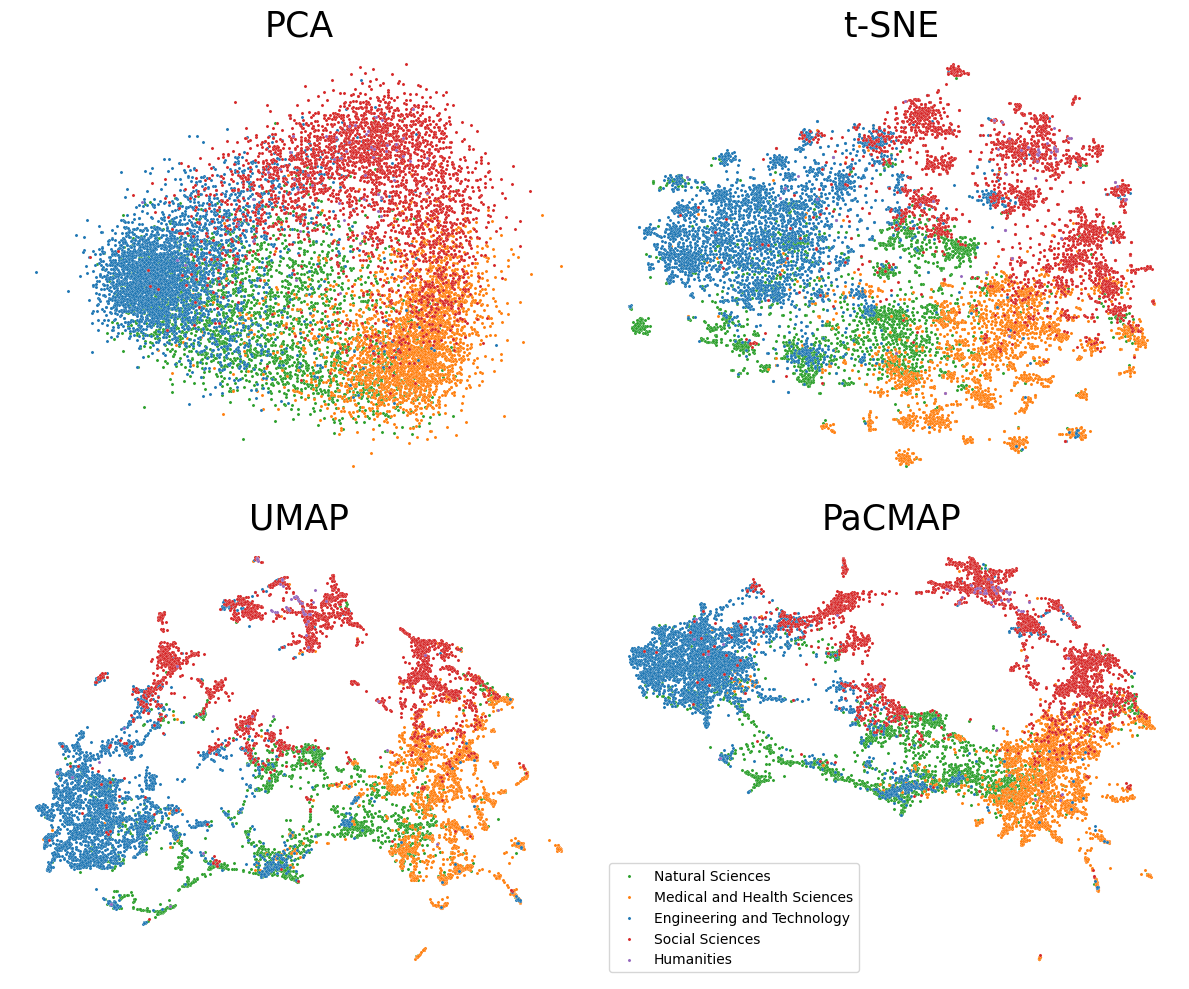

In [16]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
palette = ['tab:green','tab:orange','tab:blue','tab:red','tab:purple']
xs=[proj_2, proj, proj_1, proj_3]
ts=["PCA","t-SNE","UMAP", "PaCMAP"]
s=0
for row in ax:
    for col in row:
        m=0
        for n in journal_fields.Field.unique():
            col.set_title(ts[s], fontsize=25)
            j1=journal_fields[journal_fields.Field==n].VenueId
            col.scatter([xs[s][tokens_idx[i]][0] for i in j1],[xs[s][tokens_idx[i]][1] for i in  j1], lw=0.1, s=5, edgecolors='white', label=n, c=palette[m])
            m+=1
        s+=1
        col.axis('off')
plt.legend()
fig.tight_layout()
#plt.savefig('label.png',  bbox_inches='tight')
plt.show()

**author trajectory matrix**

In [12]:
# more processing 
journal_sequence.Year=journal_sequence.Year.astype(float)
journal_sequence=journal_sequence.dropna(subset=['Year'])[journal_sequence.Year>1959].drop_duplicates(subset=['AuthorId','PaperId'])
journal_sequence.Year=journal_sequence.Year.astype(int)
journal_sequence=journal_sequence.astype(str)
journal_sequence_1=journal_sequence[journal_sequence.VenueId.isin(tokens)].reset_index(drop=True)
journal_sequence_1['VenueSequence']=journal_sequence_1.VenueId.apply(lambda i:we_dict[i])

journal_sequence_1['VenueSequence_2d']=journal_sequence_1.VenueId.apply(lambda i:proj_3[tokens_idx[i]])

# aggregate again to get the trajectory matrix 
sequence_1=journal_sequence_1.groupby(['AuthorId']).agg({"OriginalAuthor":'first','Year':'; '.join, 'PaperId':'; '.join, 'VenueId':"; ".join, 'VenueSequence':np.vstack, 'VenueSequence_2d':np.vstack,'PaperTitle':'; '.join, 'OriginalVenue':'$;$ '.join}).reset_index()

In [13]:
len(sequence_1)

28735

In [57]:
# pca dimension reduction from 100d to 2d

ls_d=[90, 80, 70, 60, 50, 40, 30 ,20, 10, 5, 2] 

proj_ls=[PCA(n_components=i).fit_transform(X) for i in ls_d]

journal_sequence.Year=journal_sequence.Year.astype(float)
journal_sequence=journal_sequence.dropna(subset=['Year'])[journal_sequence.Year>1959].drop_duplicates(subset=['AuthorId','PaperId'])
journal_sequence.Year=journal_sequence.Year.astype(int)
journal_sequence=journal_sequence.astype(str)
journal_sequence_1=journal_sequence[journal_sequence.VenueId.isin(tokens)].reset_index(drop=True)
journal_sequence_1['VenueSequence']=journal_sequence_1.VenueId.apply(lambda i:we_dict[i])
for i in range(len(ls_d)):
    journal_sequence_1['VenueSequence_'+str(ls_d[i])]=journal_sequence_1.VenueId.apply(lambda x:proj_ls[i][tokens_idx[x]])

# aggregate again to get the trajectory matrix 
sequence_1=journal_sequence_1.groupby(['AuthorId']).agg({"OriginalAuthor":'first','Year':'; '.join, 'PaperId':'; '.join, 'VenueId':"; ".join, 'VenueSequence':np.vstack, 'VenueSequence_90':np.vstack, 
                                                         'VenueSequence_80':np.vstack, 'VenueSequence_70':np.vstack,
                                                         'VenueSequence_60':np.vstack, 'VenueSequence_50':np.vstack,
                                                         'VenueSequence_40':np.vstack, 'VenueSequence_30':np.vstack,
                                                         'VenueSequence_20':np.vstack, 'VenueSequence_10':np.vstack,
                                                         'VenueSequence_5':np.vstack, 'VenueSequence_2':np.vstack,
                                                          'PaperTitle':'; '.join, 'OriginalVenue':'$;$ '.join}).reset_index()

**Examples of author trajectories**

In [22]:
author_1=journal_sequence_1[journal_sequence_1.AuthorId=='2149865473'].VenueId.to_list()
author_2=journal_sequence_1[journal_sequence_1.AuthorId=='2125888376'].VenueId.to_list()

In [23]:
sequence_new[sequence_new.AuthorId.isin([2125888376,2149865473])][['RadiusOfGyration', 'RadiusOfGyration_2d']]

,RadiusOfGyration,RadiusOfGyration_2d
4445,3.516374,0.906621
5650,2.755841,7.250050


In [56]:
def get_quiver(proj):
    df=pd.DataFrame(columns=['x','y','time'])
    df['x']=proj[:,0]
    df['y']=proj[:,1]
    df['time']=df.index.to_list()
    x1,y1=proj[:,0],proj[:,1]
    x2=x1.copy()
    y2=y1.copy()
    a=len(x1)
    x1,y1=x1[:-1], y1[:-1]
    x2, y2= x2[1:], y2[1:]
    d=pd.DataFrame(x1, columns=['x1'])
    d['y1']=y1
    d['x2']=x2
    d['y2']=y2
    return d

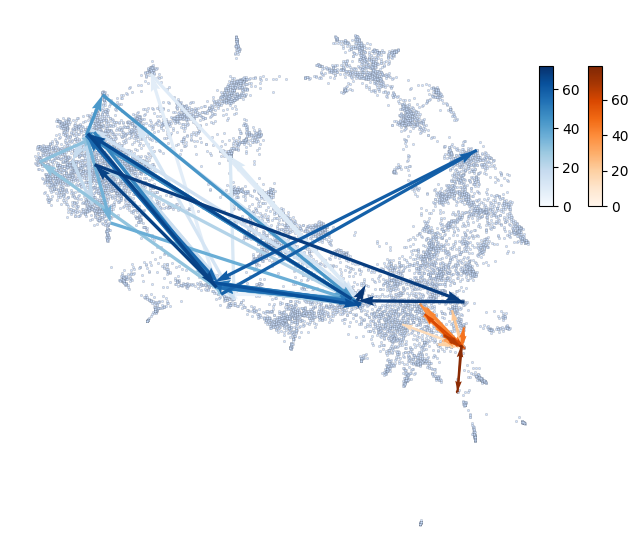

In [59]:
author_2x=np.array([proj_3[tokens_idx[n]] for n in author_2]).reshape(-1,2)
d=get_quiver(author_2x)
fig, ax = plt.subplots(1, figsize=(7,7))
cm = mpt.colormaps.get_cmap('Oranges')
sc=ax.scatter(author_2x[:,0],author_2x[:,1], c=range(len(author_2)), s=2, cmap=cm)
ax.scatter(proj_3[:,0], proj_3[:,1], lw=0.1, s=3, edgecolors='black',c="#CCE0FF", alpha=0.8)
Q=ax.quiver(d['x1'],d['y1'],d['x2']-d['x1'], d['y2']-d['y1'],  angles='xy', scale_units='xy', scale=1, color=np.array(sns.color_palette("Oranges", len(author_2))),  edgecolors='k',width=0.004)

author_1x=np.array([proj_3[tokens_idx[n]] for n in author_1]).reshape(-1,2)
d=get_quiver(author_1x)
sc_1=ax.scatter(author_1x[:,0],author_1x[:,1], c=range(len(author_1)), s=0, cmap=mpl.colormaps.get_cmap('Blues'))
Q_1=ax.quiver(d['x1'],d['y1'],d['x2']-d['x1'], d['y2']-d['y1'],  angles='xy', scale_units='xy', scale=1.005, color=np.array(sns.color_palette("Blues", len(author_1))),  edgecolors='k',width=0.006)
plt.axis('off')
cbaxes = fig.add_axes([0.95, 0.6, 0.02, 0.2])
cbaxes_1 = fig.add_axes([0.88, 0.6, 0.02, 0.2])
plt.colorbar(sc, cax = cbaxes)
plt.colorbar(sc_1, cax = cbaxes_1)
#cbaxes_1.set_ylabel('# of publications', fontsize=12)
plt.show()

### Validation of the embedding space

**qualitative similarity tests**

In [19]:

sample_list=["Proceedings of the National Academy of Sciences of the United States of America", "international conference on weblogs and social media"
        ,   "American Sociological Review", "Journal of Machine Learning Research"]

In [23]:
def find_similar(test): 
    venue_id=journal_sequence_1[journal_sequence_1['OriginalVenue'] == test].VenueId.to_list()[0]
    similar_venues=model.wv.most_similar(venue_id)
    ls=[]
    for i,j in similar_venues: 
        print((journal_sequence_1[journal_sequence_1['VenueId'] ==i].OriginalVenue.values[0], np.round(j, 3)))

In [24]:
find_similar(sample_list[0])#pnas

('Science', 0.736)
('Nature', 0.724)
('PLOS Biology', 0.64)
('Theoretical Ecology', 0.608)
('Nature Communications', 0.607)
('eLife', 0.604)
('Current Biology', 0.604)
('Cell', 0.599)
('Science Advances', 0.591)
('PLOS ONE', 0.588)


In [25]:
find_similar(sample_list[1]) #ICWSM

('web science', 0.753)
('arXiv: Social and Information Networks', 0.753)
('ACM Transactions on The Web', 0.723)
('the web conference', 0.708)
('arXiv: Computers and Society', 0.681)
('web search and data mining', 0.666)
('social informatics', 0.665)
('conference on online social networks', 0.661)
('ACM Sigweb Newsletter', 0.655)
('acm conference on hypertext', 0.647)


In [26]:
find_similar("American Sociological Review")

('Social Forces', 0.841)
('Contemporary Sociology', 0.84)
('American Journal of Sociology', 0.802)
('Social Psychology Quarterly', 0.785)
('Social Problems', 0.761)
('Sociological Forum', 0.76)
('Sociological Theory', 0.759)
('Review of Sociology', 0.722)
('Qualitative Sociology', 0.72)
('Sociological Perspectives', 0.718)


In [29]:
find_similar('Journal of Machine Learning Research')

('international conference on artificial intelligence and statistics', 0.819)
('neural information processing systems', 0.816)
('international conference on machine learning', 0.807)
('arXiv: Machine Learning', 0.804)
('Machine Learning', 0.726)
('arXiv: Learning', 0.699)
('uncertainty in artificial intelligence', 0.672)
('Neural Computation', 0.643)
('mining and learning with graphs', 0.612)
('asian conference on machine learning', 0.612)


In [34]:
find_similar('Journal of Informetrics')

('Scientometrics', 0.9)
('arXiv: Digital Libraries', 0.86)
('Frontiers in Research Metrics and Analytics', 0.792)
('Collnet Journal of Scientometrics and Information Management', 0.716)
('Learned Publishing', 0.713)
('Journal of Data and Information Science', 0.704)
('association for information science and technology', 0.699)
('Revista Espanola De Documentacion Cientifica', 0.696)
('Journal of the Association for Information Science and Technology', 0.694)
('Research Evaluation', 0.679)


In [28]:
find_similar('Scientific Reports')

('PLOS ONE', 0.71)
('Nature Communications', 0.686)
('Royal Society Open Science', 0.58)
('arXiv: Physics and Society', 0.571)
('Physical Biology', 0.56)
('Physical Review X', 0.547)
('Scientific Data', 0.544)
('EPJ Data Science', 0.539)
('bioRxiv', 0.533)
('European Respiratory Journal', 0.528)


**within subfield distance vs. within field distance**

In [36]:
# some functions
def find_distance(ls):
    venue_ls=[]
    for i in ls: 
        try: 
            venue_ls.append(journal_sequence_1[journal_sequence_1['OriginalVenue'] == i].VenueId.to_list()[0])
        except:
            pass        
    links=[n for n in combinations(venue_ls,2)]
    ls=[]
    for i,j in links:
        ls.append(1-similarity(we_dict[i], we_dict[j]))
    a=np.mean(ls)
    return (a, len(venue_ls), journal_sequence_1[journal_sequence_1['VenueId'].isin(venue_ls)].drop_duplicates("VenueId").OriginalVenue.to_list())

def find_venue(ls):
    venue_ls=[]
    for i in ls: 
        try: 
            venue_ls.append(journal_sequence_1[journal_sequence_1['OriginalVenue'] == i].OriginalVenue.to_list()[0])
        except:
            pass
    return venue_ls   

In [37]:
# scrape a list of journals from wikipedia
import requests
import bs4 as bs
url = 'https://en.wikipedia.org/wiki/List_of_social_science_journals'
#url="https://en.wikipedia.org/wiki/List_of_engineering_journals_and_magazines"
h = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.85 Safari/537.36'}
resp = requests.get(url, headers=h)
soup = bs.BeautifulSoup(resp.text, 'lxml')
abstract_urls = soup.findAll('a', title=True)

## get a list of journals
ls=""
for a in abstract_urls: 
    ls+=(a["title"]+"\n")
a=ls.split('List of scientific journals\n')[1].split('Edit section: See also\n')[0].split("Edit section: ")[1:]
j_list=list(set([j.replace(" (journal)", "") for i in a for j in i.split("\n") ]))
v_list=find_venue(j_list)


In [40]:
for i in range(len(a)):
    simi, n, names=find_distance([j.replace(" (journal)", "") for j in a[i].split("\n")])
    if n >3:
        print((simi, n, names))
        print("\n")

(0.5976783878719195, 13, ['Academy of Management Journal', 'Business Process Management Journal', 'Organization Studies', 'Strategic Management Journal', 'Journal of Management', 'Management Science', 'Organization Science', 'International Marketing Review', 'Academy of Management Review', 'Administrative Science Quarterly', 'Journal of Media Business Studies', 'Measuring Business Excellence', 'Business and Professional Communication Quarterly'])


(0.19083848595619202, 5, ['Journal of Communication', 'Communication Theory', 'Communication Research', 'Human Communication Research', 'Communication Monographs'])


(0.5374279571904077, 10, ['Educational Technology & Society', 'Studies in Higher Education', 'Review of Educational Research', 'Research in Learning Technology', 'Harvard Educational Review', 'American Educational Research Journal', 'Teachers College Record', 'College Teaching', 'Educational Researcher', 'Educational Administration Quarterly'])


(0.6443013057112694, 5, ['Ecolo

In [ ]:
## 1000 random samples 
import random 
from tqdm.notebook import tqdm
ls=[]
for i in tqdm(range(1000)):
    ls.append(find_distance(random.sample(v_list,10)))

In [204]:
colors=['#9aafd2', '#e9b99a', '#d6c4df', '#c4e7a6', '#fbb3b2', '#dddddd']
names=['Communication', 'Geography', 'Sociology', 'Political science', 'Business, management & organization theory', 'Education and educational technology']

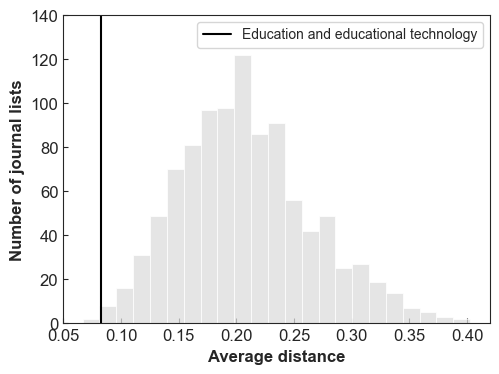

In [205]:
ls_e_d=[a for a, b, c in ls]
fig, ax=plt.subplots(1,1, figsize=(5.5,4))
i=-1
sns.histplot(ls_e_d, ax=ax, color=colors[i],edgecolor='white', linewidth=0.5)
plt.axvline(0.08291205830044217, color="black", label=names[i])
ax.legend(loc='upper right', fontsize=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylim(0, 140)
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
ax.set_ylabel('Number of journal lists', fontsize=12,fontweight='bold')
ax.set_xlabel('Average distance', fontsize=12,fontweight='bold');

**element-centric similarity test**

In [42]:
from clusim.clustering import Clustering, print_clustering
import clusim.sim as sim
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [41]:
# kmeans clusters on the 2d map
scaler = StandardScaler()
scaler.fit(proj_3)
X_std=scaler.transform(proj_3)
model = KMeans(
    n_clusters=4)
kmean=model.fit_predict(X_std)

In [43]:
clusters_idx={k:kmean[v] for v, k in enumerate(tokens)}
journal_sequence_1['Clusters']=journal_sequence_1.VenueId.apply(lambda x: clusters_idx[x])
journal_fields['Clusters']=journal_fields.VenueId.apply(lambda x: clusters_idx[x])

In [50]:
journal_fields['Cluster']=journal_fields.VenueId.apply(lambda x: clusters_idx[x])
cluster_dict={'Natural Sciences':1, 'Medical and Health Sciences':3,
       'Engineering and Technology':2, 'Social Sciences':0, 'Humanities':0}
journal_fields['Cluster_true']=journal_fields['Field'].apply(lambda x: [cluster_dict[x]])
journal_fields['Cluster']=journal_fields['Cluster'].apply(lambda x: [x])

In [51]:
dict_1=dict(journal_fields[['VenueId','Cluster_true']].values)
dict_2=dict(journal_fields[['VenueId','Cluster']].values)
clustering1 = Clustering(elm2clu_dict = dict_1)
clustering2 = Clustering(elm2clu_dict = dict_2)


In [52]:
print("Element-centric Similarity:", sim.element_sim(clustering1, clustering2, alpha = 0.9) )

Element-centric Similarity: 0.55012466601023


In [53]:
print("Element-centric Similarity for each element:")
elementScores, relabeled_elements = sim.element_sim_elscore(clustering1, clustering2, alpha = 0.9) 
print(elementScores)

Element-centric Similarity for each element:
[0.16952104 0.75645864 0.16952104 ... 0.10656855 0.60331675 0.17004717]


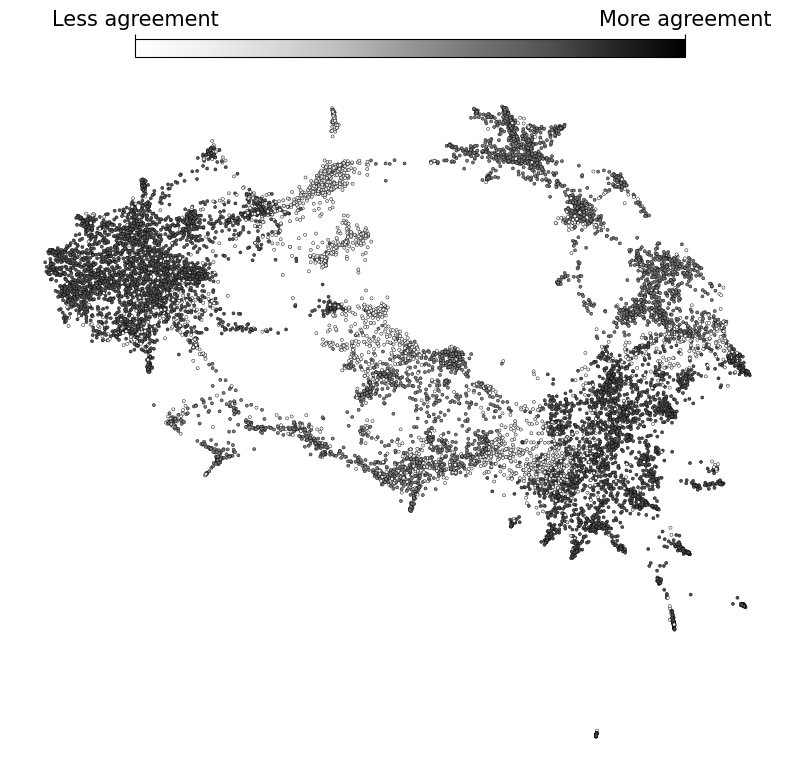

In [54]:
fig, ax = plt.subplots(1,1, figsize=(10,9))
cm = plt.cm.get_cmap('Greys')
sc=plt.scatter([proj_3[tokens_idx[i]][0] for i in journal_fields.VenueId],[proj_3[tokens_idx[i]][1] for i in  journal_fields.VenueId],  s=5, vmin=0, vmax=1, edgecolors='black',  c=elementScores,lw=0.3,  cmap=cm)
cax = fig.add_axes([0.25,0.9, 0.55, 0.02])
cb=plt.colorbar(sc, ax=ax, orientation='horizontal', cax=cax)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
cb.set_ticks([0, 1])
cb.set_ticklabels(['Less agreement',"More agreement"], )
for t in cb.ax.get_xticklabels():
     t.set_fontsize(15)
ax.axis('off');
#plt.savefig('pacmap_agreement.png',  bbox_inches='tight')

<hr>

### author trajectory measures

In [14]:
# some measurements 
sequence_1['PublicationCount']=sequence_1.VenueSequence.apply(lambda x:len(x))
sequence_1['UniqueVenue']=sequence_1.VenueId.apply(lambda x: list(set(x.split('; '))))
sequence_1['YearSpan']=sequence_1.Year.apply(lambda x:eval(max(x.split('; ')))-eval(min(x.split('; ')))+1)
sequence_1['TotalDistanceNorm']=sequence_1.VenueSequence.apply(lambda x: distance_norm(x))
sequence_1['MeanDistanceNorm']=sequence_1.VenueSequence.apply(lambda x: distance_mean(x))
sequence_1['Velocity']=sequence_1['TotalDistanceNorm']/sequence_1['YearSpan']
sequence_1['StdDistanceNorm']=sequence_1.VenueSequence.apply(lambda x: distance_std(x))

sequence_1['AvereageDistanceMidpoint']=sequence_1.VenueSequence.apply(lambda x: Averagetocentroid(x))
sequence_1['RadiusOfGyration']=sequence_1.VenueSequence.apply(lambda x: Gyration(x))
sequence_1['Midpoint']=sequence_1.VenueSequence.apply(lambda x: middle(x))
sequence_1['JumpSize']=sequence_1.VenueSequence.apply(lambda x:JumpSize(x))
sequence_1['Trips']=sequence_1.VenueId.apply(lambda x: trips(x))
sequence_1['ShannonEntropy_trips']=sequence_1.Trips.apply(lambda x: estimate_shannon_entropy(x))
sequence_1['ShannonEntropy_places']=sequence_1.UniqueVenue.apply(lambda x: estimate_shannon_entropy(x))

# 2d measurements 

#sequence_1['Midpoint_2d']=sequence_1.VenueSequence_2d.apply(lambda x: middle(x))
sequence_1['RadiusOfGyration_2d']=sequence_1.VenueSequence_2d.apply(lambda x: Gyration(x))
sequence_1['ConvexHullArea']=sequence_1.VenueSequence_2d.apply(lambda x: ConvexArea(x))

In [15]:
# num of authors with more than 20 publications
sequence_2=sequence_1[sequence_1.PublicationCount>20]
sequence_2.shape
#sequence_2=sequence_1.copy()

(10740, 25)

In [63]:
## from 100d to 2d, pca test
sequence_1['PublicationCount']=sequence_1.VenueSequence.apply(lambda x:len(x))
sequence_1['UniqueVenue']=sequence_1.VenueId.apply(lambda x: list(set(x.split('; '))))
sequence_1['YearSpan']=sequence_1.Year.apply(lambda x:eval(max(x.split('; ')))-eval(min(x.split('; ')))+1)
sequence_1['RadiusOfGyration']=sequence_1.VenueSequence.apply(lambda x: Gyration(x))
for i in range(len(ls_d)):
    sequence_1['RadiusOfGyration_'+str(ls_d[i])]=sequence_1['VenueSequence_'+str(ls_d[i])].apply(lambda x: Gyration(x))

In [69]:
for i in ls_d:
    print(str(i) +"d:")
    print(scipy.stats.pearsonr(sequence_2['RadiusOfGyration_'+str(i)], sequence_2.AverageCitation) )

90d:
PearsonRResult(statistic=-0.08432865353542832, pvalue=2.152543941121397e-18)
80d:
PearsonRResult(statistic=-0.0788289777483729, pvalue=2.9204038626698574e-16)
70d:
PearsonRResult(statistic=-0.07465054926622423, pvalue=9.793257500185746e-15)
60d:
PearsonRResult(statistic=-0.06543199645927725, pvalue=1.1716193710574298e-11)
50d:
PearsonRResult(statistic=-0.0592088855514938, pvalue=8.393956841820453e-10)
40d:
PearsonRResult(statistic=-0.04976928023341745, pvalue=2.5026707159527246e-07)
30d:
PearsonRResult(statistic=-0.03267159670463943, pvalue=0.0007130688026795156)
20d:
PearsonRResult(statistic=-0.009406427391310031, pvalue=0.32996285347009613)
10d:
PearsonRResult(statistic=0.03298987193895671, pvalue=0.0006320074033086803)
5d:
PearsonRResult(statistic=0.043741322439049365, pvalue=5.83739330136807e-06)
2d:
PearsonRResult(statistic=0.04813133176791041, pvalue=6.114558425360885e-07)


Text(0.5, 0, 'N_dims')

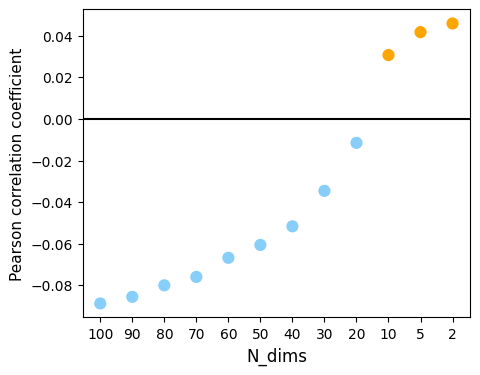

In [148]:
ls=[scipy.stats.pearsonr(sequence_2['RadiusOfGyration_'+str(i)], sequence_2.AverageCitation)[0] for i in ls_d]
a=[scipy.stats.pearsonr(sequence_2['RadiusOfGyration'], sequence_2.AverageCitation)[0]] +ls
b=[str(i) for i in [100]+ls_d]
fig, ax=plt.subplots(figsize=(5,4
                            )) 
plt.scatter(b, a, c=['lightskyblue' if i <0 else 'orange' for i in a ], s=60)
plt.axhline(y=0.0, color='black', linestyle='-')
ax.set_ylabel("Pearson correlation coefficient",size = 11)
ax.set_xlabel("N_dims",size = 12)

In [31]:
# add some author background information 
sequence_2.AuthorId=sequence_2.AuthorId.astype(np.int64)
sequence_new=sequence_2.merge(pub[['AuthorId','Background', 'CitationCount', 'PaperCount']], on=['AuthorId'])

sequences.AuthorId=sequences.AuthorId.astype(np.int64)
sequence_new=sequence_new.merge(sequences[['AuthorId', "AverageCitation", 'Age','MedianCitation','Percentile75Citation', "AverageCitation_log"]], on=['AuthorId'])
sequence_new.Age=sequence_new.Age.astype(np.int64)
sequence_new['Background_1']=sequence_new.AuthorId.apply(lambda x: fields_2[int(x)])
sequence_new['Field_1']=sequence_new.Background_1.apply(lambda x: field_dict[x])

In [17]:
sequence_new_1=sequence_new[['TotalDistanceNorm', 'MeanDistanceNorm', 'StdDistanceNorm','Velocity','AvereageDistanceMidpoint','ConvexHullArea', 'RadiusOfGyration', 'RadiusOfGyration_2d','ShannonEntropy_places']]
sequence_new_1.columns=['TotalDistance', 'MeanDistance', 'StdDistance', 'Velocity', 'AvereageDistanceMidpoint', 
        'ConvexHullArea', 'RadiusOfGyration',  'RadiusOfGyration2D','ShannonEntropy']

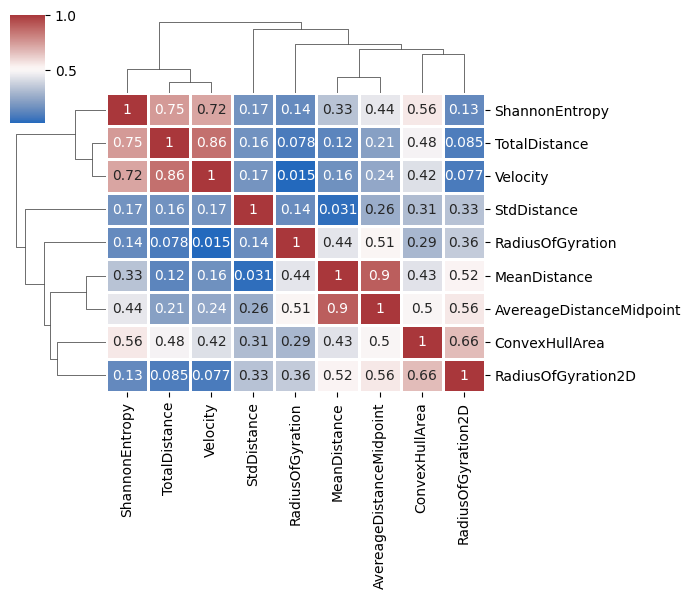

In [59]:
# measure correlation 
ms=['TotalDistance', 'MeanDistance', 'StdDistance', 'Velocity',
        'ConvexHullArea', 'RadiusOfGyration',  'RadiusOfGyration2D','ShannonEntropy', 'AvereageDistanceMidpoint']
#fig, ax=plt.subplots(figsize=(7,5
#                             ))    
g=sns.clustermap(sequence_new_1[ms].corr(),  linewidths=1,cmap="vlag", annot=True, figsize=(7,6))
plt.show();

In [64]:
new_sample=sequence_new.copy()
#sequence_new=sequence_new[sequence_new.PublicationCount<15906].reset_index(drop=True)

In [65]:
def generate(new_sample, x):
    deciles=np.quantile(new_sample[x].values, q=[i*0.1 for i in range(11)])
    my_dict_1=[]
    for i in range(len(deciles)-1):
        ls=[]
        for j in range(len(new_sample)):
            if deciles[i]<=new_sample[x].values[j]<deciles[i+1]:
                ls.append(j)
        my_dict_1.append(ls)
    return my_dict_1

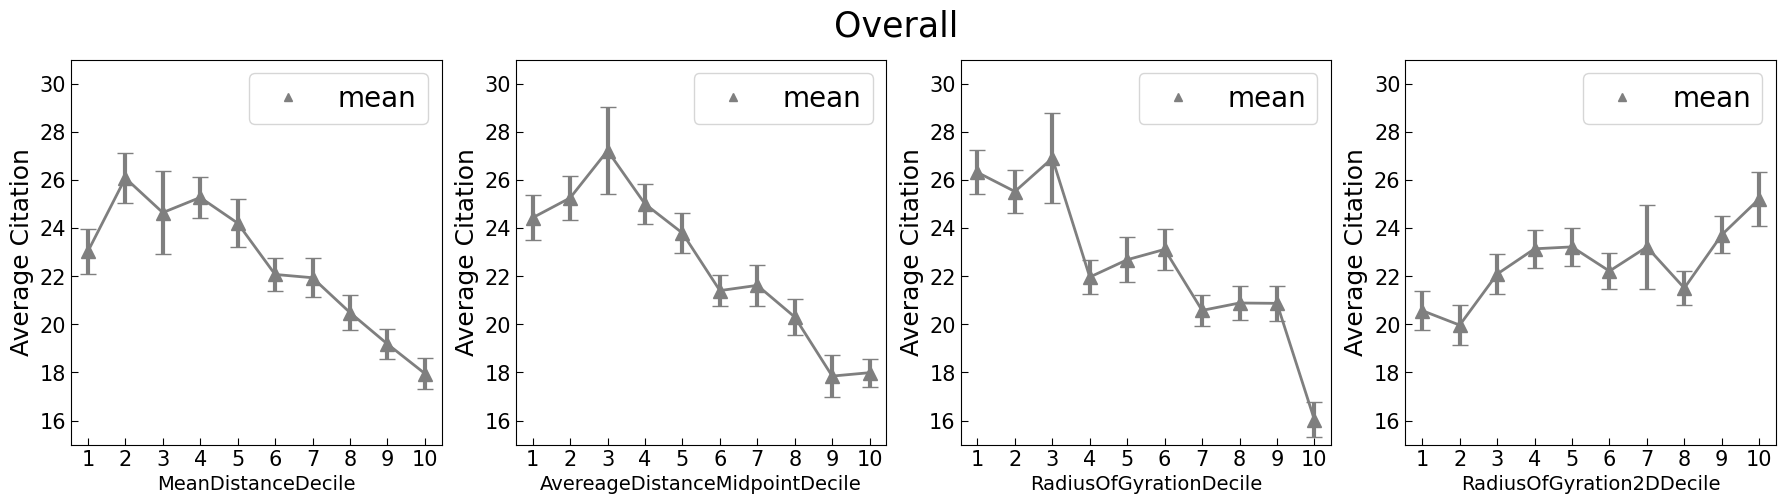

In [66]:
%matplotlib inline
colors = np.array(sns.color_palette("Greys", 15))
fig, axes = plt.subplots(1,4,figsize=(22, 5))
props = dict(widths=0.5,patch_artist=True, medianprops=dict(color="yellow"), showfliers=False)
label=[ 'MeanDistance',
       'AvereageDistanceMidpoint', 'RadiusOfGyration', 'RadiusOfGyration2D']
ls=[generate(new_sample, i) for i in ['MeanDistanceNorm',
       'AvereageDistanceMidpoint', 'RadiusOfGyration', 'RadiusOfGyration_2d']]
a=0
fig.suptitle('Overall', fontsize=25) 
for ax1 in axes:
    ey= [new_sample.iloc[ls[a][i]].AverageCitation.mean() for i in range(len(ls[a]))]
    e1 = [new_sample.iloc[ls[a][i]].AverageCitation.std()/np.sqrt(len(new_sample.iloc[ls[a][i]].AverageCitation)) for i in range(10)]
    ex=list(range(1,11))
    ax1.set_ylabel("Average Citation",size = 18)
    ax1.set_xlabel(label[a]+'Decile',size = 14)
    ax1.errorbar(ex, ey, e1, marker='^', capsize=6,elinewidth=3,markersize=10, c='tab:gray', markeredgewidth=1, linewidth=2)
    ax1.grid(False)
    ax1.plot([], [], '^', linewidth=1, color='tab:gray', label='mean')
    #mn=new_sample.AverageCitation.mean()
    #ax1.hlines(y=mn, xmin=0, xmax=11,  linestyle='--', color='grey', label='Mean ='+str(int(mn)))
    a+=1
    lgnd=ax1.legend(loc='upper right', fontsize=20, )
    #lgnd.legendHandles[0]._legmarker.set_markersize(10)
    ax1.set_ylim(15,31)
    ax1.set_xticks(np.arange(min(ex), max(ex)+1, 1.0))
    ax1.xaxis.set_tick_params(labelsize=15, direction='in',length=5)
    ax1.yaxis.set_tick_params(labelsize=15, direction='in',length=5)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
#plt.savefig('overall')
plt.show()

In [67]:
mpl.rcParams.update(mpl.rcParamsDefault)
labels = [item.get_text() for item in ax1.get_xticklabels()]

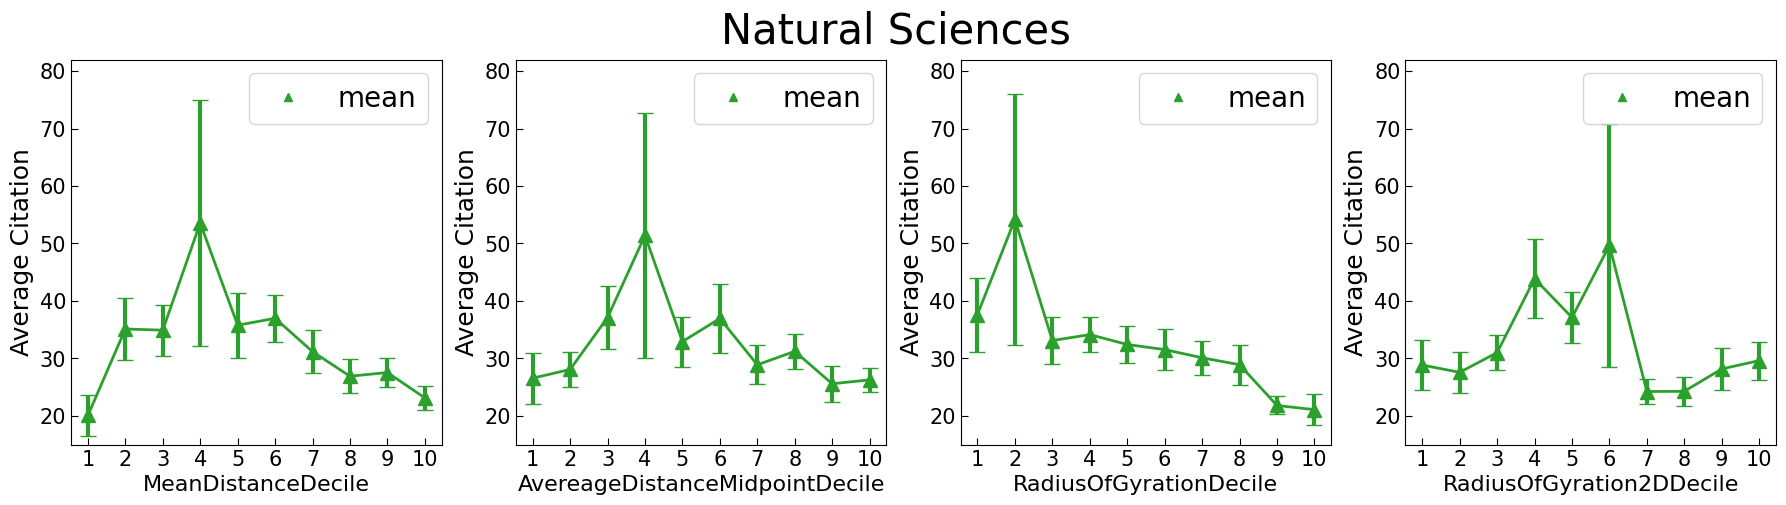

In [72]:
f=1
n= ['Social Sciences',
       'Natural Sciences','Engineering and Technology',  'Medical and Health Sciences','Humanities']
palette = ['tab:red','tab:green','tab:blue','tab:orange','purple']
fig, axes = plt.subplots(1,4,figsize=(22, 5))
fig.suptitle(n[f], fontsize=30) 
new_sample_1=new_sample[new_sample.Field_1==n[f]].reset_index(drop=True)
label=[ 'MeanDistance',
       'AvereageDistanceMidpoint', 'RadiusOfGyration', 'RadiusOfGyration2D']
ls=[generate(new_sample_1, i) for i in ['MeanDistanceNorm',
       'AvereageDistanceMidpoint', 'RadiusOfGyration', 'RadiusOfGyration_2d']]

a=0
for ax1 in axes:
    ey= [new_sample_1.iloc[ls[a][i]].AverageCitation.mean() for i in range(10)]
    e1 = [new_sample_1.iloc[ls[a][i]].AverageCitation.std()/np.sqrt(len(new_sample_1.iloc[ls[a][i]].AverageCitation)) for i in range(len(ls[a]))]
    ex=list(range(1, 11))
    ax1.set_ylabel("Average Citation",size = 18)
    ax1.errorbar(ex, ey, e1, marker='^', capsize=6,elinewidth=3,markersize=10, c=palette[f],  markeredgewidth=1, linewidth=2)
    ax1.set_xlabel(label[a]+'Decile',size = 16)
    ax1.plot([], [], '^', linewidth=1, color=palette[f],  label='mean')
    a+=1
    lgnd=ax1.legend(loc='upper right', fontsize=20)
    #lgnd.legendHandles[0]._legmarker.set_markersize(10)
    ax1.set_ylim(15, 82)
    ax1.set_xticks(np.arange(min(ex), max(ex)+1, 1.0))
    #ax1.set_yticks(np.arange(10, 32, 2))
    ax1.xaxis.set_tick_params(labelsize=15, direction='in',length=5)
    ax1.yaxis.set_tick_params(labelsize=15, direction='in',length=5)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
plt.show()

**The radius of gyration as a function of publication number**

In [34]:
def time_gyration(x):
    ls=[]
    for i in range(2, len(x)):
        ls.append(Gyration(x[:i]))
    return ls

In [35]:
sequence_new['t_rg']=sequence_new.VenueSequence.apply(lambda x: time_gyration(x))
sequence_new['t_rg_2d']=sequence_new.VenueSequence_2d.apply(lambda x: time_gyration(x))

In [129]:
## 40 samples 
sub=sequence_new.sample(40)
sub.AuthorId.to_list()

[2005248799,
 2255277545,
 651214150,
 2140312290,
 2104603560,
 2101432548,
 1990955389,
 2284024090,
 154829372,
 2125850141,
 153204822,
 1972457923,
 2128550989,
 276580745,
 2161461259,
 2090228834,
 2096117490,
 2135111705,
 2030089775,
 2097252768,
 2154173639,
 2133793109,
 2152584006,
 2229329610,
 2149494377,
 2149865473,
 298914714,
 1983999465,
 2161928135,
 2152813519,
 212253142,
 1996123574,
 2061781787,
 2167046215,
 2281366827,
 2157020507,
 2559429521,
 1984923616,
 2033280294,
 2472236676]

In [ ]:
a=sub.t_rg.values
a_1=sub.t_rg_2d.values
c=sub.JumpSize.values

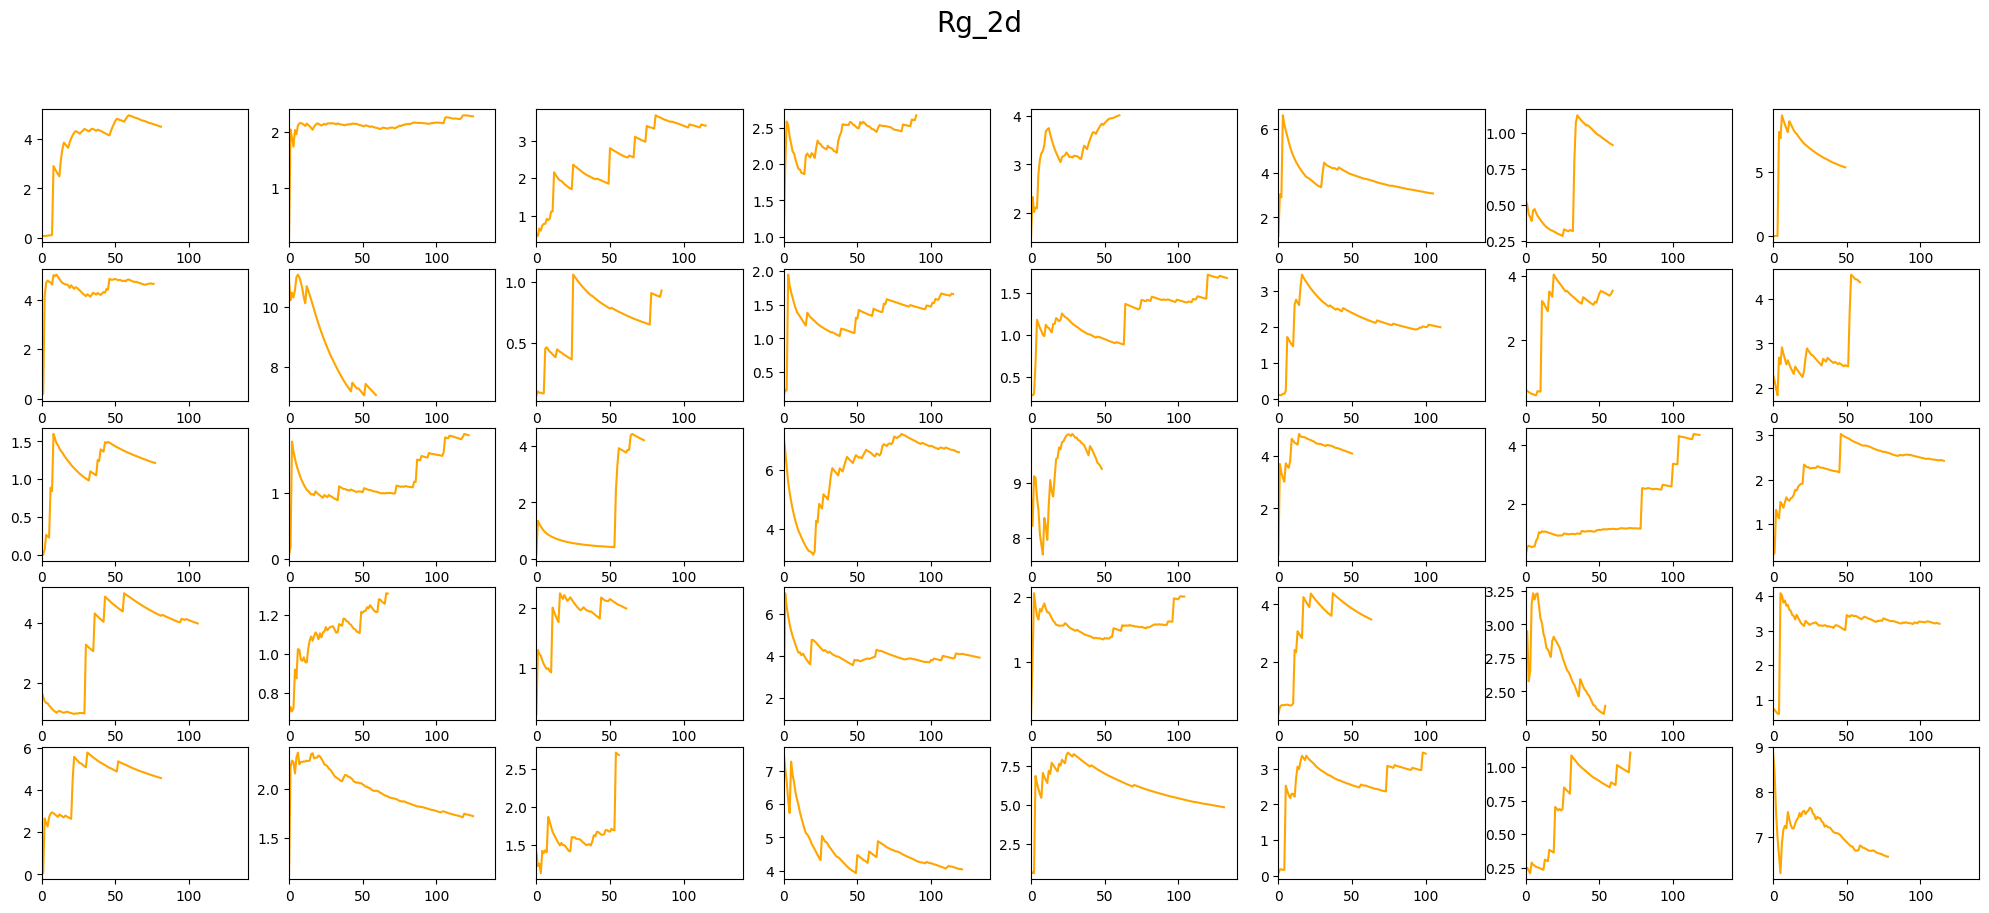

In [141]:

fig=plt.figure(figsize=(25, 10))
fig.suptitle('Rg_2d', fontsize=20) 
b=0
for i in range(5):
    for j in range(8):
        ax=plt.subplot2grid((5,8), (i,j))
        ax.plot(a_1[b], color='orange')
        ax.set_xlim(0, 140)
        #ax.set_ylim(0, 5)
        ax.grid(False)
        #ax.set_xlabel('Paper')
        #if b %8==0:
            #ax.set_ylabel('Rg')
        b+=1
plt.show()

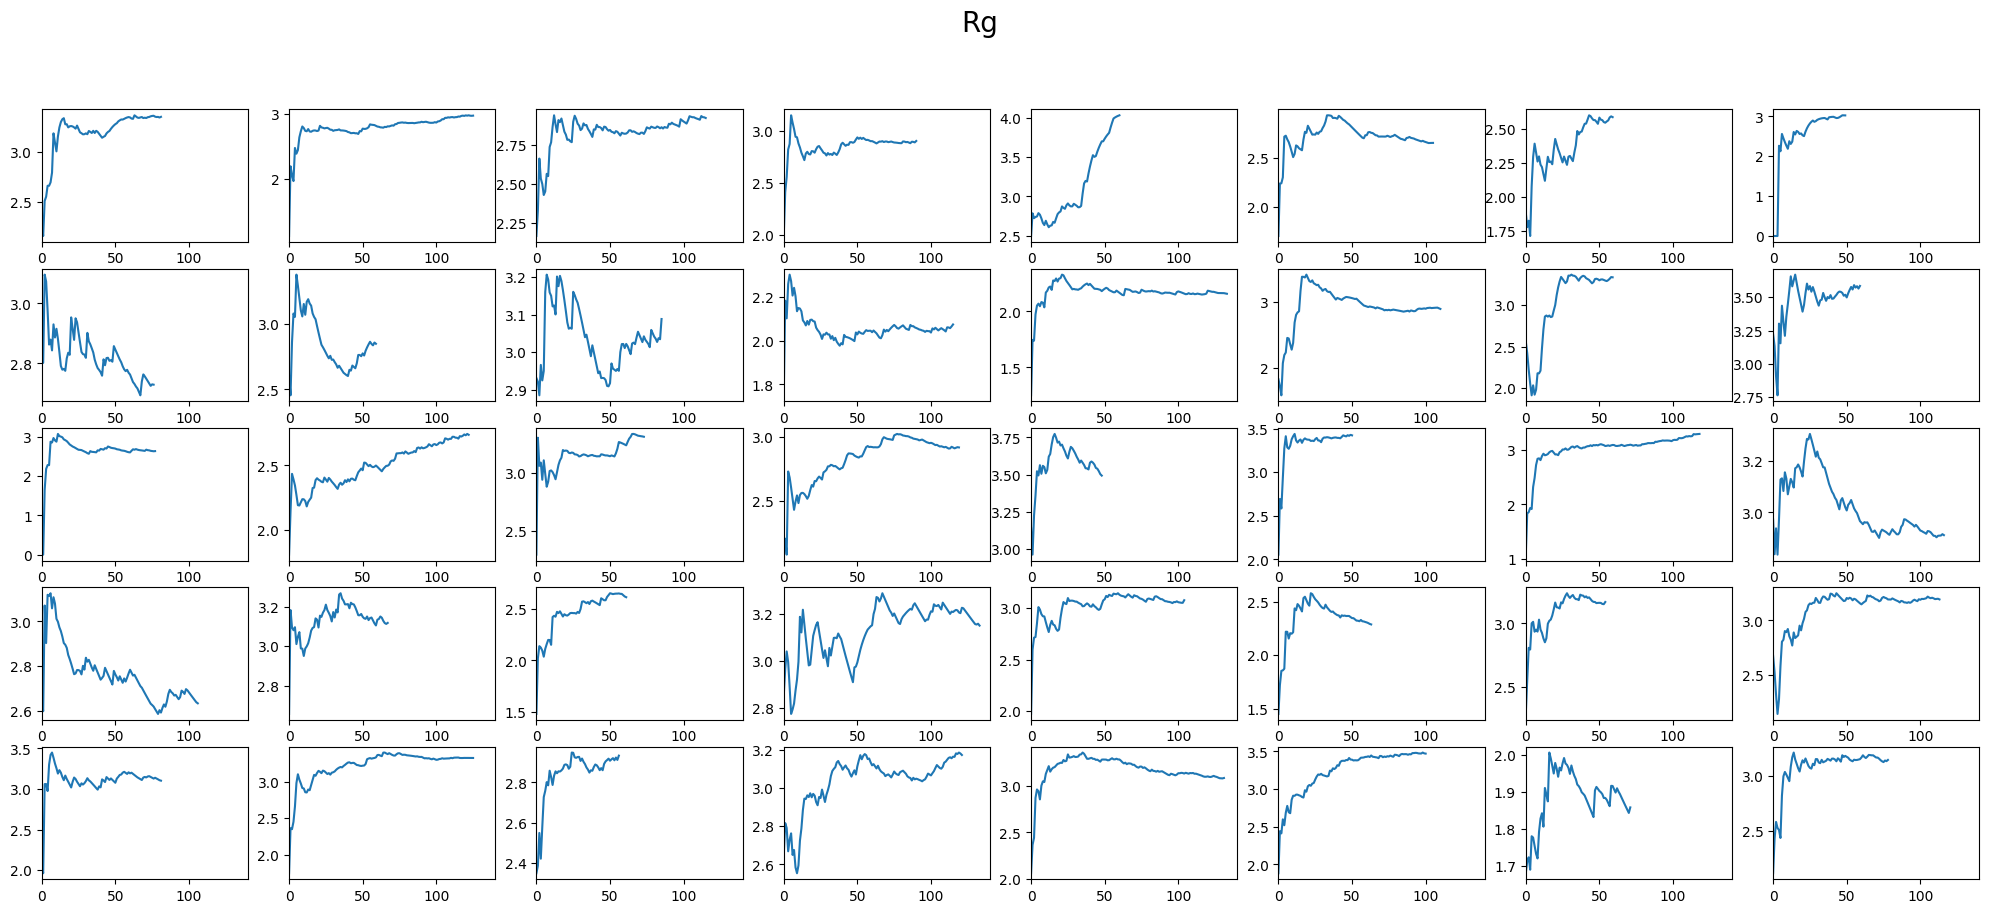

In [142]:
fig=plt.figure(figsize=(25, 10))
fig.suptitle('Rg', fontsize=20) 
a_2=[[0]+ i for i in a]
b=0
for i in range(5):
    for j in range(8):
        ax=plt.subplot2grid((5,8), (i,j))
        ax.plot(a[b])
        ax.set_xlim(0, 140)
        #ax.set_ylim(0, 5)
        ax.grid(False)
        #ax.set_xlabel('Paper')
        #if b %8==0:
        #    ax.set_ylabel('Rg')
        b+=1
plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(25, 10))
fig.suptitle('JumpSize', fontsize=20) 
b=0
for i in range(5):
    for j in range(8):
        ax=plt.subplot2grid((5,8), (i,j))
        sns.distplot(c[b],  kde=True)
        b+=1
        #ax.set_xlim(0, 1)
        #ax.set_ylim(0, 1)
        ax.grid(False)
        ax.set_xlabel('')
        ax.set_ylabel('')
plt.show()

<hr>

### regression

In [32]:
# map background to OECD fields
sequence_new=sequence_new[sequence_new.Background.isin(top_0)].reset_index(drop=True)


In [33]:
# get the last known affiliation from mag
affiliation=pd.read_pickle('../../data/affilication_detail0.pickle')
df= affiliation.drop_duplicates(subset=['AffiliationId'])[['Latitude', 'Longitude']].reset_index(drop=True)
ids=affiliation.drop_duplicates(subset=['AffiliationId']).AffiliationId.reset_index(drop=True).values
coordinates = [(df.Latitude[i].round(2), df.Longitude[i].round(2)) for i in range(len(df))]

# from coordinate to country 
my_dict={}
for i in range(len(coordinates)):
    try:
        my_dict[ids[i]]=reverse_geocode.search([coordinates[i]])[0]
    except:
        pass

# from country to continent
for i in range(len(affiliation)):
    try:
        inf=my_dict[affiliation.AffiliationId[i]]
        affiliation.loc[i, 'Region']= inf['country']
        affiliation.loc[i, 'Continent']= pc.country_alpha2_to_continent_code(inf['country_code'])
    except:
        pass

In [34]:
# get continent for authors
sequence_new=sequence_new.merge(affiliation[['AuthorId', "Region", 'Continent']], on=['AuthorId'])

In [35]:
# standardize the rg
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(sequence_new.RadiusOfGyration.values.reshape(-1, 1))
X_std_1=scaler.transform(sequence_new.RadiusOfGyration.values.reshape(-1, 1))
sequence_new['RadiusOfGyration_std']=[i[0] for i in X_std_1]

# 2d
scaler = StandardScaler()
scaler.fit(sequence_new.RadiusOfGyration_2d.values.reshape(-1, 1))
X_std=scaler.transform(sequence_new.RadiusOfGyration_2d.values.reshape(-1, 1))
sequence_new['RadiusOfGyration_std_1']=[i[0] for i in X_std]

In [36]:
#name gender 
gender=pd.read_csv("../../data/author_gender.csv")
gender.gender.fillna('UNKNOWN', inplace=True)
df=sequence_new.copy()
def get_first_name(x): 
    return x.split(' ')[0]
df['Name_first']=df.OriginalAuthor.apply(lambda x:get_first_name(x).replace(".", "") if(pd.notnull(x)) else x)

ind=gender[gender.probability < 0.8].index
for i in ind: 
    gender.loc[i, "gender"]='UNKNOWN'
gender.Name_first.fillna('NA', inplace=True)
gender_dict=dict(zip(gender.Name_first, gender.gender))
df["Name_gender"]=df.Name_first.apply(lambda x: gender_dict[x])

In [37]:
df=df.dropna(subset=['AverageCitation','PublicationCount','RadiusOfGyration_std','RadiusOfGyration_std_1','Age', 'Continent', 'Field_1']).reset_index(drop=True)

In [38]:
df_1.columns

Index(['AuthorId', 'OriginalAuthor', 'Year', 'PaperId', 'VenueId',
       'VenueSequence', 'VenueSequence_2d', 'PaperTitle', 'OriginalVenue',
       'PublicationCount', 'UniqueVenue', 'YearSpan', 'TotalDistanceNorm',
       'MeanDistanceNorm', 'Velocity', 'StdDistanceNorm',
       'AvereageDistanceMidpoint', 'RadiusOfGyration', 'Midpoint', 'JumpSize',
       'Trips', 'ShannonEntropy_trips', 'ShannonEntropy_places',
       'RadiusOfGyration_2d', 'ConvexHullArea', 'Background', 'CitationCount',
       'PaperCount', 'AverageCitation', 'Age', 'MedianCitation',
       'Percentile75Citation', 'AverageCitation_log', 'Background_1',
       'Field_1', 'Region', 'Continent', 'RadiusOfGyration_std',
       'RadiusOfGyration_std_1', 'Name_first', 'Name_gender'],
      dtype='object')

In [39]:
df_1=df.copy()
#df_1['AverageCitation_log'] = np.log(df_1.AverageCitation+1)

In [43]:
# regression
from statsmodels.formula.api import ols

fit = ols('Percentile75Citation ~ RadiusOfGyration_std+PublicationCount+ C(Field_1)+Age+C(Continent)+ C(Name_gender)', data=df_1).fit(cov_type='HC1') 
fit_1 = ols('AverageCitation~ RadiusOfGyration_std+PublicationCount+ C(Field_1)+ Age +C(Continent)+ C(Name_gender)', data=df_1).fit(cov_type='HC1') 
fit_2 = ols('AverageCitation_log~ RadiusOfGyration_std+ PublicationCount+C(Field_1)+Age +C(Continent)+ C(Name_gender)', data=df_1).fit(cov_type='HC1')
fit_3 = ols('RadiusOfGyration_std~ RadiusOfGyration_std_1', data=df_1).fit(cov_type='HC1')

In [41]:
# get the residuals 
residuals=df_1.AverageCitation_log-fit_1.predict(df_1)
df_1['Residual']=  df_1.RadiusOfGyration_std-df_1.RadiusOfGyration_std_1*fit_3.params[1]+fit_3.params[0]

In [57]:
from statsmodels.iolib.summary2 import summary_col
res=summary_col([ fit_1,fit, fit_2],stars=True,float_format='%0.2f', info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}, regressor_order=fit.params.index.tolist())

In [58]:
res

,AverageCitation,Percentile75Citation,AverageCitation_log
Intercept,-5.81***,-1.70,1.05***
,(1.96),(1.68),(0.06)
C(Field_1)[T.Humanities],-12.03**,-12.32***,-0.84***
,(5.04),(4.69),(0.21)
C(Field_1)[T.Medical and Health Sciences],0.10,1.13*,-0.06***
,(0.67),(0.60),(0.01)
C(Field_1)[T.Natural Sciences],13.05***,11.16***,0.32***
,(2.60),(0.99),(0.02)
C(Field_1)[T.Social Sciences],10.18***,12.42***,0.35***
,(0.77),(0.67),(0.02)


**Correlation between Rg and Rg_2d**

In [89]:
from scipy.stats import gaussian_kde
x=df.RadiusOfGyration_2d
y=df.RadiusOfGyration
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

In [90]:
scaler = StandardScaler()
scaler.fit(df.AverageCitation.values.reshape(-1, 1))
X_std=scaler.transform(df.AverageCitation.values.reshape(-1, 1))
citations=[i[0] for i in X_std]

In [92]:
scipy.stats.pearsonr(df.RadiusOfGyration_2d, df.RadiusOfGyration)  

PearsonRResult(statistic=0.3606023914775089, pvalue=2.43614e-319)

In [93]:
df1=df.sort_values("AverageCitation", ascending=False).reset_index(drop=True).iloc[:].sort_values("AverageCitation")

In [96]:
g = sns.JointGrid(data=df1, x="RadiusOfGyration_2d", y="RadiusOfGyration",)
g.plot_joint(sns.scatterplot,   s=10,  cmap='jet', c= df1.AverageCitation.values,  alpha=0.4, linewidth=0, sizes=(10, 5))
g.plot_marginals(sns.kdeplot, color='#040484', fill=True)
g.set_axis_labels('RadiusOfGyration2DSpace', 'RadiusOfGyrationFullSpace', fontsize=12)
plt.text(-1.5, 5, 'r=0.36', fontsize=16 )
g.fig.set_figwidth(6)
g.fig.set_figheight(5)

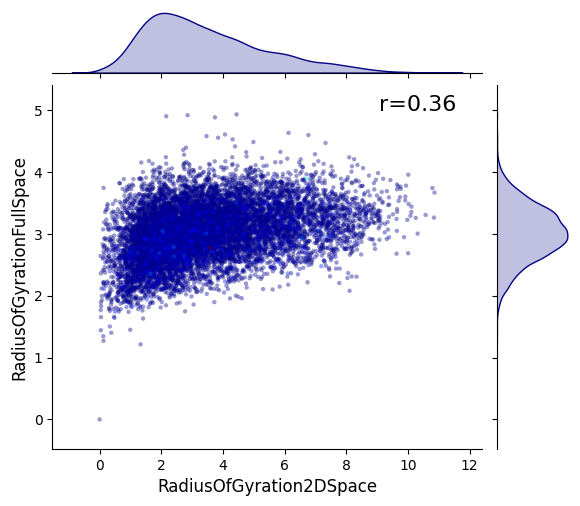

In [97]:
plt.show()